In [ ]:
# https://www.kaggle.com/jacobramey
# https://github.com/rameyjm7

import numpy as np
import h5py, scipy.io as sio, os, sklearn
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
import tensorflow as tf
import os

# ------------------------------
# Load DeepRadar2022 dataset (local)
# ------------------------------
path = os.path.join(os.getcwd(),"..", "data", "DeepRadar2022")
print("Loading DeepRadar2022 from:", path)

def load_h5(filepath, key):
    with h5py.File(filepath, "r") as f:
        return np.array(f[key], dtype="float32").T

def load_mat(filepath, key):
    d = sio.loadmat(filepath)
    return d[key]

# Core signal data
X_train = load_h5(os.path.join(path, "X_train.mat"), "X_train")
X_val   = load_h5(os.path.join(path, "X_val.mat"), "X_val")
X_test  = load_h5(os.path.join(path, "X_test.mat"), "X_test")

# Label matrices and metadata
Y_train = load_mat(os.path.join(path, "Y_train.mat"), "Y_train")
Y_val   = load_mat(os.path.join(path, "Y_val.mat"), "Y_val")
Y_test  = load_mat(os.path.join(path, "Y_test.mat"), "Y_test")

lbl_train = load_mat(os.path.join(path, "lbl_train.mat"), "lbl_train")
lbl_val   = load_mat(os.path.join(path, "lbl_val.mat"), "lbl_val")
lbl_test  = load_mat(os.path.join(path, "lbl_test.mat"), "lbl_test")

print("✅ DeepRadar2022 dataset successfully loaded from local path.")


# Extract modulation class and SNR
cls_train, snr_train = lbl_train[:,0].astype(int)-1, lbl_train[:,1]
cls_val,   snr_val   = lbl_val[:,0].astype(int)-1,   lbl_val[:,1]
cls_test,  snr_test  = lbl_test[:,0].astype(int)-1,  lbl_test[:,1]

# ------------------------------
# Filter training/validation by SNR ≥ -6 dB
# ------------------------------
train_mask = snr_train >= -6
val_mask   = snr_val >= -6
X_train, Y_train, snr_train = X_train[train_mask], Y_train[train_mask], snr_train[train_mask]
X_val,   Y_val,   snr_val   = X_val[val_mask],   Y_val[val_mask],   snr_val[val_mask]

print(f"Training samples kept: {X_train.shape[0]} | Validation: {X_val.shape[0]} | Test: {X_test.shape[0]}")

# ------------------------------
# Shuffle
# ------------------------------
np.random.seed(1961)
X_train, Y_train, snr_train = sklearn.utils.shuffle(X_train, Y_train, snr_train, random_state=1961)
X_val,   Y_val,   snr_val   = sklearn.utils.shuffle(X_val, Y_val, snr_val, random_state=1961)
X_test,  Y_test,  snr_test  = sklearn.utils.shuffle(X_test, Y_test, snr_test, random_state=1961)

# ------------------------------
# Normalize IQ per sample
# ------------------------------
def normalize_iq(X):
    Xn = np.empty_like(X)
    for i in range(X.shape[0]):
        scale = np.max(np.abs(X[i])) + 1e-12
        Xn[i] = X[i] / scale
    return Xn

X_train = normalize_iq(X_train)
X_val   = normalize_iq(X_val)
X_test  = normalize_iq(X_test)

# ------------------------------
# Append SNR as a third channel
# ------------------------------
def append_snr_feature(X, snr):
    X_out = []
    for i in range(X.shape[0]):
        snr_col = np.full((X.shape[1], 1), snr[i] / 20.0)  # normalized to roughly [-0.6, 1]
        X_out.append(np.concatenate([X[i], snr_col], axis=1))
    return np.array(X_out, dtype=np.float32)

X_train = append_snr_feature(X_train, snr_train)
X_val   = append_snr_feature(X_val, snr_val)
X_test  = append_snr_feature(X_test, snr_test)

input_shape = (1024, 3)
num_classes = 23

# ------------------------------
# Enable mixed precision
# ------------------------------
mixed_precision.set_global_policy("mixed_float16")

# ------------------------------
# Build CNN + Bidirectional LSTM model
# ------------------------------
def build_cnn_bilstm(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, 5, activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(128, 3, activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling1D(2),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(num_classes, activation="softmax", dtype="float32")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_cnn_bilstm(input_shape, num_classes)
model.summary()

# ------------------------------
# Training setup
# ------------------------------
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    ModelCheckpoint("deepradar2022_cnn_bilstm_highsnr.keras", save_best_only=True)
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=35,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# ------------------------------
# Evaluate on full test set (all SNRs)
# ------------------------------
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTest Accuracy (all SNRs): {acc*100:.2f}%")

Y_pred = model.predict(X_test, verbose=0)
y_true = np.argmax(Y_test, axis=1)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix (CNN + BiLSTM, Trained ≥ –6 dB, Evaluated All)")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred))

# ------------------------------
# Accuracy vs SNR
# ------------------------------
unique_snrs = sorted(np.unique(snr_test))
acc_snr = []
for snr in unique_snrs:
    idx = np.where(snr_test == snr)[0]
    acc_snr.append(accuracy_score(y_true[idx], y_pred[idx]) * 100)

plt.figure(figsize=(8,5))
plt.plot(unique_snrs, acc_snr, 'b-o')
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy (%)")
plt.title("Recognition Accuracy vs SNR (CNN + BiLSTM, Trained ≥ –6 dB)")
plt.grid(True)
plt.show()


In [ ]:
# ------------------------------
# Save final model in .keras format and plot labeled confusion matrices
# ------------------------------
# Define model path
model_path = os.path.join("..", "models", "deepradar2022_cnn_bilstm_final.keras")

# Save model architecture, weights, and optimizer state in one file
model.save(model_path, include_optimizer=True)
print(f"Model saved successfully at: {os.path.abspath(model_path)}")

Notebook directory: /home/rameyjm7/workspace/ML-wireless-signal-classification/notebooks
Project root: /home/rameyjm7/workspace/ML-wireless-signal-classification
Dataset directory: /home/rameyjm7/workspace/ML-wireless-signal-classification/data/DeepRadar2022
Model path: /home/rameyjm7/workspace/ML-wireless-signal-classification/models/deepradar2022_cnn_bilstm_final.keras
Loading DeepRadar2022 dataset...
Loaded shapes:
X_test: (156400, 1024, 2)
Y_test: (156400, 23)
Labels: (156400, 6)
Loading trained CNN+BiLSTM model...


/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model loaded.


2025-11-18 21:33:10.040156: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1921843200 exceeds 10% of free system memory.
2025-11-18 21:33:12.274727: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1921843200 exceeds 10% of free system memory.
2025-11-18 21:33:16.031994: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002



Test accuracy (all SNRs): 84.33%


2025-11-18 21:34:29.770977: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1921843200 exceeds 10% of free system memory.
2025-11-18 21:34:31.611894: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1921843200 exceeds 10% of free system memory.


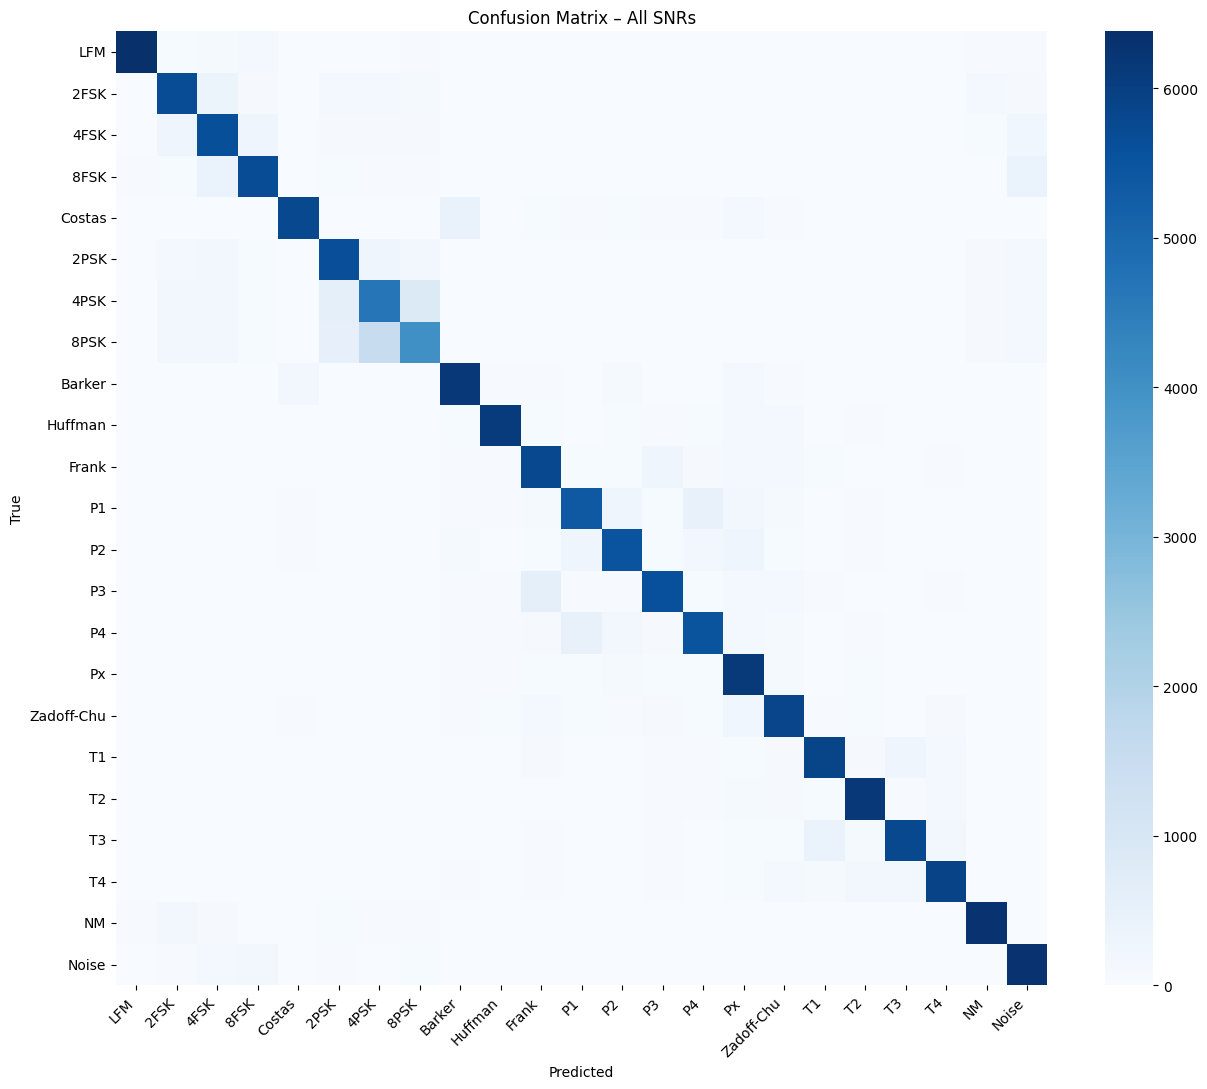

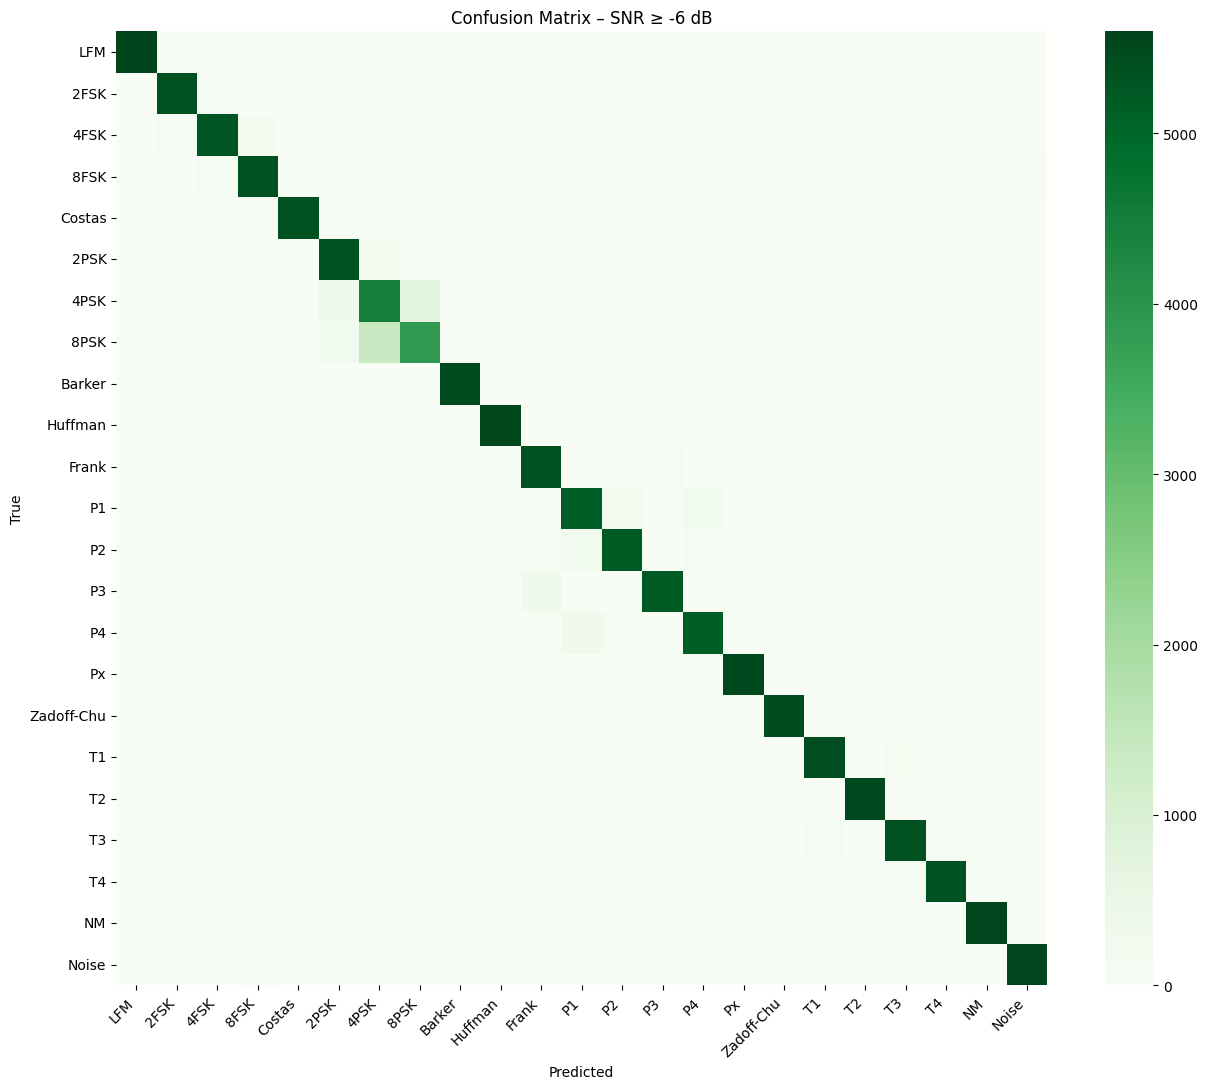


Classification Report – All SNRs:
              precision    recall  f1-score   support

         LFM      0.973     0.938     0.955      6800
        2FSK      0.820     0.836     0.828      6800
        4FSK      0.769     0.826     0.797      6800
        8FSK      0.864     0.837     0.850      6800
      Costas      0.927     0.854     0.889      6800
        2PSK      0.787     0.829     0.807      6800
        4PSK      0.676     0.686     0.681      6800
        8PSK      0.737     0.592     0.657      6800
      Barker      0.877     0.906     0.892      6800
     Huffman      0.936     0.898     0.916      6800
       Frank      0.804     0.851     0.827      6800
          P1      0.829     0.790     0.809      6800
          P2      0.845     0.812     0.828      6800
          P3      0.865     0.823     0.843      6800
          P4      0.821     0.807     0.814      6800
          Px      0.758     0.904     0.825      6800
  Zadoff-Chu      0.818     0.862     0.839   

In [3]:
# ================================================
# DeepRadar2022 – Full Evaluation (Standalone Cell)
# ================================================
import os
import numpy as np
import h5py
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ---------------------------------------------------------
# Resolve project paths (safe for notebooks anywhere)
# ---------------------------------------------------------
notebook_dir = Path().resolve()
project_root = notebook_dir.parent

data_dir = project_root / "data" / "DeepRadar2022"
model_path = project_root / "models" / "deepradar2022_cnn_bilstm_final.keras"

print("Notebook directory:", notebook_dir)
print("Project root:", project_root)
print("Dataset directory:", data_dir)
print("Model path:", model_path)

assert data_dir.exists(), f"DeepRadar2022 directory not found: {data_dir}"
assert model_path.exists(), f"Model file missing: {model_path}"

# ---------------------------------------------------------
# Loader helpers
# ---------------------------------------------------------
def load_h5(filepath, key):
    with h5py.File(filepath, "r") as f:
        return np.array(f[key], dtype="float32").T

def load_mat(filepath, key):
    d = sio.loadmat(filepath)
    return d[key]

# ---------------------------------------------------------
# Load test data
# ---------------------------------------------------------
print("Loading DeepRadar2022 dataset...")
X_test  = load_h5(data_dir / "X_test.mat",  "X_test")
Y_test  = load_mat(data_dir / "Y_test.mat", "Y_test")
lbl_test = load_mat(data_dir / "lbl_test.mat", "lbl_test")  # columns: [class_id, SNR]

cls_test = lbl_test[:, 0].astype(int) - 1
snr_test = lbl_test[:, 1]

print("Loaded shapes:")
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)
print("Labels:", lbl_test.shape)

# ---------------------------------------------------------
# Normalize IQ per sample
# ---------------------------------------------------------
def normalize_iq(X):
    Xn = np.empty_like(X)
    for i in range(X.shape[0]):
        scale = np.max(np.abs(X[i])) + 1e-12
        Xn[i] = X[i] / scale
    return Xn

X_test = normalize_iq(X_test)

# ---------------------------------------------------------
# Append SNR as a 3rd channel
# ---------------------------------------------------------
def append_snr_feature(X, snr):
    out = []
    for i in range(X.shape[0]):
        snr_col = np.full((X.shape[1], 1), snr[i] / 20.0)  # normalized
        out.append(np.concatenate([X[i], snr_col], axis=1))
    return np.array(out, dtype=np.float32)

X_test = append_snr_feature(X_test, snr_test)

# ---------------------------------------------------------
# Load model
# ---------------------------------------------------------
print("Loading trained CNN+BiLSTM model...")
model = load_model(model_path)
print("Model loaded.")

# ---------------------------------------------------------
# Evaluate
# ---------------------------------------------------------
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTest accuracy (all SNRs): {acc*100:.2f}%")

# Predict
Y_pred = model.predict(X_test, verbose=0)
y_true = np.argmax(Y_test, axis=1)
y_pred = np.argmax(Y_pred, axis=1)

# ---------------------------------------------------------
# Labels
# ---------------------------------------------------------
mod_labels = [
    "LFM", "2FSK", "4FSK", "8FSK", "Costas",
    "2PSK", "4PSK", "8PSK",
    "Barker", "Huffman", "Frank",
    "P1", "P2", "P3", "P4", "Px",
    "Zadoff-Chu",
    "T1", "T2", "T3", "T4",
    "NM", "Noise"
]

# ---------------------------------------------------------
# Confusion Matrix – All SNRs
# ---------------------------------------------------------
cm_all = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(13, 11))
sns.heatmap(
    cm_all, cmap="Blues", annot=False,
    xticklabels=mod_labels, yticklabels=mod_labels
)
plt.title("Confusion Matrix – All SNRs")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Confusion Matrix – High SNR (>= -6 dB)
# ---------------------------------------------------------
high_mask = snr_test >= -6
y_true_high = y_true[high_mask]
y_pred_high = y_pred[high_mask]

cm_high = confusion_matrix(y_true_high, y_pred_high)
plt.figure(figsize=(13, 11))
sns.heatmap(
    cm_high, cmap="Greens", annot=False,
    xticklabels=mod_labels, yticklabels=mod_labels
)
plt.title("Confusion Matrix – SNR ≥ -6 dB")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Reports
# ---------------------------------------------------------
print("\nClassification Report – All SNRs:")
print(classification_report(y_true, y_pred, target_names=mod_labels, digits=3))

print("\nClassification Report – SNR ≥ -6 dB:")
print(classification_report(y_true_high, y_pred_high, target_names=mod_labels, digits=3))
